# Packages

In [ ]:
##uncomment to install libraries
!pip install gputil
!pip install psutil
!pip install humanize

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7395 sha256=4f3a0a169dc281ab48bb224e82b6b1ac5597de226e964ead0ce475597d323fc3
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision
import torchvision
import torchvision.transforms.v2 as transforms

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix

# utils
import time
import numpy as np
import os
import copy

##gpu
import psutil
import humanize
import GPUtil as GPU

In [ ]:
##to find out about the information for computational requirements for the gpu

GPUs = GPU.getGPUs()

if GPUs:
    gpu = GPUs[0]  # only picked one gpu, we only had one available
    print(f"GPU Name: {gpu.name}")
    print(f"GPU Driver: {gpu.driver}")
    print(f"GPU Memory Total: {humanize.naturalsize(gpu.memoryTotal)}")
    print(f"GPU Memory Free: {humanize.naturalsize(gpu.memoryFree)}")
    print(f"GPU Memory Used: {humanize.naturalsize(gpu.memoryUsed)}")
else:
    print("No GPU available.")

# CPU information
print(f"\nCPU Cores: {psutil.cpu_count(logical=False)}")
print(f"CPU Threads: {psutil.cpu_count(logical=True)}")

GPU Name: Tesla T4
GPU Driver: 525.105.17
GPU Memory Total: 15.4 kB
GPU Memory Free: 15.1 kB
GPU Memory Used: 0 Bytes

CPU Cores: 1
CPU Threads: 2


In [ ]:
!nvidia-smi

Sun Nov 19 21:58:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [ ]:
if os.path.exists("./data/cinic-10-python.tar.gz") == False:
    download = True
else:
    download = False

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transforms.ToTensor()
)
dataset_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transforms.ToTensor()
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


100%|██████████| 170498071/170498071 [00:03<00:00, 44156336.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
CINIC10_mean = np.mean(dataset_train.data / 255.0, axis=(0, 1, 2))
CINIC10_std = np.std(dataset_train.data / 255.0, axis=(0, 1, 2))
transform = transforms.Compose(
    [
        # first cast the data to a pytorch tensor
        transforms.ToTensor(),
        # then define mean and std for the normalization (RMK: for each channel)
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize(mean=CINIC10_mean, std=CINIC10_std),
    ]
)

if os.path.exists("./data/cinic-10-python.tar.gz") == False:
    download = True
else:
    download = False

dataset_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transform
)
dataset_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transform
)

classes = dataset_train.classes
print(f"length of training dataset {len(dataset_train)}")
print(f"length of test dataset {len(dataset_test)}")

## Training dataset split

In [ ]:
torch.manual_seed(42)
# This just splits the indices into two subsets basically
train_subset, val_subset = torch.utils.data.random_split(dataset_train, [0.8, 0.2])

## Data loaders

In [ ]:
batch_size = 128  # hyperparameter
trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
valloader = torch.utils.data.DataLoader(
    val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)
testloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

# Model

In [ ]:
class VGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(VGG13, self).__init__()
        self.batch_norm = batch_norm

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training

### Utils

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta  # minimum improvement to reset patience
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 21:58:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train loop

In [ ]:
def train_model(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = 0
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                accuracy = correct / total
                training_loss.append(running_loss / tot_samples)
                training_accuracy.append(accuracy)
                print(
                    f"Epoch {epoch + 1}"
                    + f"\tTraining loss: {loss.item():.6f}"
                    + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                    + f"\tTraining partial incremental accuracy: {accuracy * 100:.2f}"
                )
                running_loss = 0
                tot_samples = 0
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    # calculate the batch loss
                    accuracy = correct / total
                    validation_loss.append(running_loss / tot_samples)
                    validation_accuracy.append(accuracy)
                    print(
                        f"Epoch {epoch + 1}"
                        + f"\tValidation loss: {loss:.6f}"
                        + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                        + f"\tAccuracy: {accuracy * 100:.2f}"
                    )
                    running_loss = 0
                    tot_samples = 0

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [ ]:
torch.manual_seed(42)
vgg = VGG13(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    vgg.parameters(),
    lr=0.0005,
)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 30

vgg = vgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model(
    vgg,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 2.116426	Running loss: 2.265466	Training partial incremental accuracy: 17.19
Epoch 1	Training loss: 1.923353	Running loss: 2.045530	Training partial incremental accuracy: 18.75
Epoch 1	Training loss: 1.860823	Running loss: 1.912664	Training partial incremental accuracy: 20.57
Epoch 1	Training loss: 1.748710	Running loss: 1.843619	Training partial incremental accuracy: 25.39
Epoch 1	Training loss: 1.633733	Running loss: 1.765297	Training partial incremental accuracy: 26.88
Epoch 1	Validation loss: 1.523960	Running loss: 1.666591	Accuracy: 34.69
Epoch 1	Validation loss: 1.744914	Running loss: 1.700379	Accuracy: 33.93
Epoch 1	Validation loss: 1.720902	Running loss: 1.743330	Accuracy: 33.37
Epoch 1	Validation loss: 1.715513	Running loss: 1.661350	Accuracy: 33.58
Epoch 1	Validation loss: 1.682145	Running loss: 1.681731	Accuracy: 33.60
Epoch 2	Training loss: 1.720276	Running loss: 1.653879	Training partial incremental accuracy: 32.81
Epoch 2	Training loss: 1.499136	Run

### Test

In [ ]:
# test accuracy
vgg.eval()
correct = 0
total = 0

start = time.time()
with torch.no_grad():
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        # forward pass
        output = vgg(data)
        _, pred = torch.max(output, dim=1)
        total += target.size(0)
        correct += (pred == target).sum().item()
end = time.time()

print(f"Test accuracy: {correct / total * 100:.2f}%")
print(f"Test took {end - start:.2f} seconds")

Test accuracy: 77.62%
Test took 2.82 seconds


### Inference time test

In [ ]:
vgg.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(0, len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    start = time.time()
    output = vgg(img)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Output: {output}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.06623650 seconds
Output: tensor([[-4.2138, -4.1851,  0.4360,  2.1447, -0.8460,  1.3874,  2.4490, -4.2522,
         -2.5968, -4.3164]], device='cuda:0')
Prediction: frog
Target: dog


In [ ]:
#to check memory usage and gpu status
!nvidia-smi


Sun Nov 19 22:03:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    37W /  70W |   2167MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves

Text(0, 0.5, 'Loss')

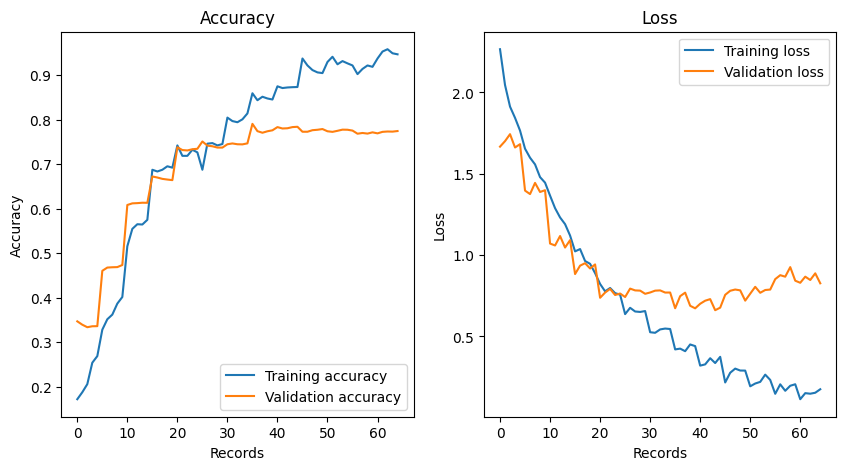

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(training_accuracy, label="Training accuracy")
axs[0].plot(validation_accuracy, label="Validation accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Records")
axs[0].set_ylabel("Accuracy")

axs[1].plot(training_loss, label="Training loss")
axs[1].plot(validation_loss, label="Validation loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss")
axs[1].set_xlabel("Records")
axs[1].set_ylabel("Loss")

### Confusion matrix

In [ ]:
def compute_confusion_matrix(model, testloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            _, pred = torch.max(output, dim=1)
            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return confusion_matrix(y_true, y_pred, normalize="true") * 100

In [ ]:
conf_mat = compute_confusion_matrix(vgg, testloader)
print(conf_mat)

[[86.7  1.1  2.7  1.1  0.9  0.2  0.7  1.6  1.5  3.5]
 [ 0.6 88.3  0.2  0.1  0.2  0.2  0.9  0.1  0.6  8.8]
 [ 7.5  0.1 68.4  4.1  7.3  4.5  4.9  1.9  0.6  0.7]
 [ 2.   0.2  7.6 55.3  6.  15.8  6.2  4.8  0.4  1.7]
 [ 2.2  0.1  7.2  3.9 71.6  3.7  4.6  6.4  0.2  0.1]
 [ 1.1  0.2  4.2 14.2  3.2 68.7  1.6  6.1  0.2  0.5]
 [ 0.6  0.3  4.1  5.9  2.4  1.1 84.7  0.4  0.1  0.4]
 [ 2.4  0.1  1.4  2.8  3.7  3.9  0.3 84.   0.   1.4]
 [12.8  3.7  0.7  1.2  0.2  0.   0.4  0.4 77.5  3.1]
 [ 2.3  4.6  0.2  0.3  0.1  0.   0.7  0.5  0.3 91. ]]


<Axes: >

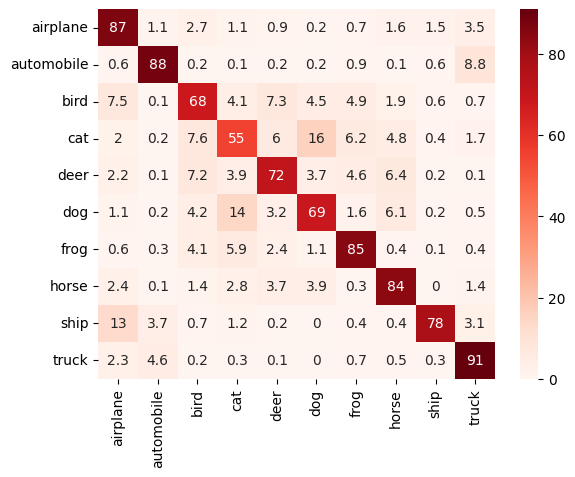

In [ ]:
sns.heatmap(
    conf_mat, annot=True, cmap=cm.Reds, xticklabels=classes, yticklabels=classes
)

# Early exit

## B-NET

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 22:03:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    36W /  70W |   2167MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Early exit decision criterion

In [ ]:
def entropy(x):
    p = F.softmax(x.detach(), dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

### Model

In [ ]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [ ]:
class BVGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                e += 1
            if inference:
                # x is a single image, otherwise we would have to loop over the batch dimension
                H = entropy(x_ee)
                if torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        if inference:
            return x, H, e
        return out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

### Custom loss function

In [ ]:
class JointCrossEntropy(nn.Module):
    def __init__(self):
        super(JointCrossEntropy, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = 0
        for output in outputs:
            loss += self.cross_entropy(output, targets)
        return loss

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 22:03:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    36W /  70W |   2167MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training loop

In [ ]:
def train_model_ee(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [ ]:
torch.manual_seed(42)
bvgg = BVGG13(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee(
    bvgg,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.0501	Accuracy: [47.66 43.75 45.31 38.28 36.72 32.81 29.69 29.69 26.56 25.  ]
Epoch 1	Training loss: 16.6616	Accuracy: [51.17 48.83 46.88 43.75 41.41 38.28 34.77 35.16 32.03 27.34]
Epoch 1	Training loss: 15.0742	Accuracy: [55.73 51.56 49.74 46.35 43.49 40.36 37.76 37.5  35.16 30.99]
Epoch 1	Training loss: 14.2478	Accuracy: [57.03 52.93 52.15 48.05 45.31 42.19 40.43 39.84 37.3  33.01]
Epoch 1	Training loss: 13.6669	Accuracy: [58.91 54.84 53.91 49.38 46.72 43.59 42.81 41.72 40.16 36.56]
Epoch 1	Validation loss: 12.4546	Accuracy: [71.09 64.84 67.97 68.75 66.41 56.25 57.03 57.03 54.69 50.  ]
Epoch 1	Validation loss: 12.4939	Accuracy: [66.8  61.33 64.06 61.33 59.77 52.34 52.34 51.95 51.56 48.83]
Epoch 1	Validation loss: 12.7777	Accuracy: [66.15 61.46 63.8  60.68 58.85 53.12 52.6  52.86 52.34 48.44]
Epoch 1	Validation loss: 12.6039	Accuracy: [65.04 60.35 63.28 59.18 56.64 52.34 50.59 51.37 51.95 48.63]
Epoch 1	Validation loss: 12.6974	Accuracy: [64.06 60.31 62.97 57.

### Test data

In [ ]:
# test accuracy
bvgg.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = bvgg(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average test accuracy is {100*avg_acc}")

Exit 1 test accuracy: 68.45%
Test took 2.96 seconds
Exit 2 test accuracy: 75.88%
Test took 2.94 seconds
Exit 3 test accuracy: 76.81%
Test took 3.81 seconds
Exit 4 test accuracy: 77.50%
Test took 3.81 seconds
Exit 5 test accuracy: 78.83%
Test took 3.00 seconds
Exit 6 test accuracy: 79.11%
Test took 2.87 seconds
Exit 7 test accuracy: 79.63%
Test took 2.96 seconds
Exit 8 test accuracy: 79.26%
Test took 4.36 seconds
Exit 9 test accuracy: 79.14%
Test took 2.89 seconds
Exit 10 test accuracy: 78.91%
Test took 2.83 seconds
the average test accuracy is 78.91


### Inference time

In [ ]:
bvgg.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(0, len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg.set_exit_threshold(0.1)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.02180815 seconds
Exit: 2
Entropy: tensor([0.0004])
Output: tensor([[ -1.3913, -13.4552,  -3.2957,  -9.6123,  -4.2679,  -3.3748,  -9.1214,
          -6.2446,   6.8211,  -4.7944]])
Prediction: ship
Target: ship


In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 22:09:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    41W /  70W |   2841MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves.

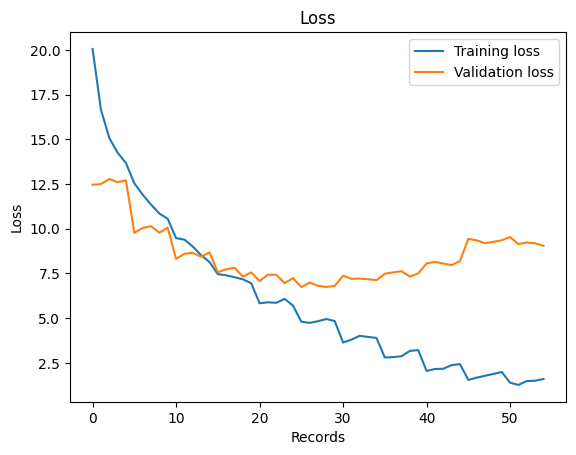

In [ ]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(55, 10)


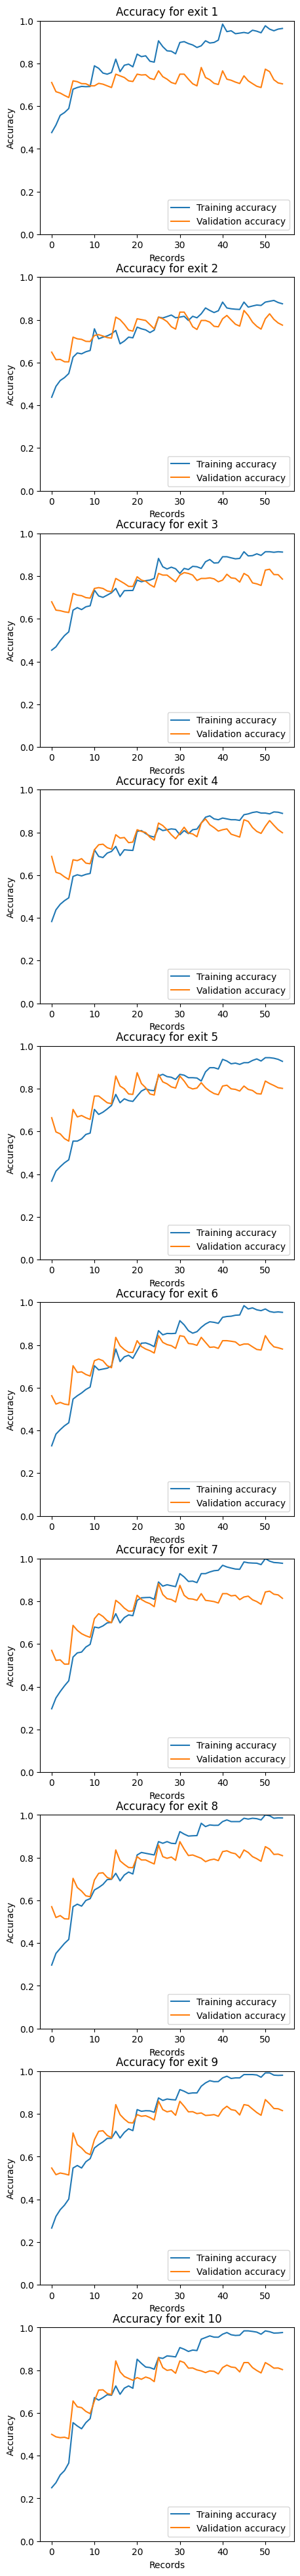

In [ ]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

## Proposed algorithm for training

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 22:09:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   2841MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Early exit decision criterion.

Based on:
- Entropy of the logits;
- Probability of the guess.

In [ ]:
def entropy(x):
    p = F.softmax(x, dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

In [ ]:
def find_max_prob(x):
    p = F.softmax(x, dim=1)
    return torch.max(p, dim=1).values

### Model

Function to create auxiliary branches in the network, based on the input shape of the image and the number of input channels (aka the depth of the feature map).

In [ ]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [ ]:
class BVGG13_v2(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v2, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        # create the early exit layers
        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                # evaluate the early exit
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                # compute the decision function
                H = entropy(x_ee)
                g_functions.append(H)
                e += 1
                # check if we can exit during inference phase
                if inference and torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # evaluate the final exit
        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        out.append(x)
        # compute the decision function
        last_H = entropy(x)
        # check if we can exit during inference phase
        if inference:
            return x, last_H, len(soft_out)

        # compute the soft-conditional output
        soft_out.append(x)

        # traverse the outputs in reverse order
        k = len(g_functions) - 1
        for o in out[-2::-1]:
            h = g_functions[k].unsqueeze(1)
            k -= 1
            f_tilde = h * o + (1 - h) * soft_out[-1]
            soft_out.append(f_tilde)

        soft_out.reverse()
        # training exit
        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 22:09:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   2841MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training loop

In [ ]:
def train_model_ee_v2(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = model(data)
            # calculate the batch loss
            loss = loss_fn(soft_output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
            # break
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output, soft_output = model(data)
                loss = loss_fn(soft_output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)
        # break

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch}")
            if early_stop.restore_best_weights:
                print(f"Restored model trained at epoch {epoch - early_stop.counter}")
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [ ]:
torch.manual_seed(42)
bvgg_v2 = BVGG13_v2(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v2.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v2.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v2,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.5879	Accuracy: [28.91 36.72 32.81 31.25 29.69 29.69 28.12 26.56 25.78 18.75]
Epoch 1	Training loss: 17.8443	Accuracy: [27.73 35.94 32.81 35.16 32.42 32.03 30.86 30.08 31.64 26.56]
Epoch 1	Training loss: 16.1751	Accuracy: [32.55 41.93 38.28 39.84 34.38 36.46 33.07 32.81 33.59 30.47]
Epoch 1	Training loss: 15.4672	Accuracy: [32.62 42.19 37.11 41.21 34.57 36.13 34.57 34.18 33.98 31.25]
Epoch 1	Training loss: 14.8881	Accuracy: [33.59 42.5  36.56 40.   35.31 37.81 37.19 36.41 33.91 33.28]
Epoch 1	Validation loss: 14.2065	Accuracy: [43.75 57.03 36.72 48.44 41.41 52.34 46.88 53.12 45.31 39.84]
Epoch 1	Validation loss: 14.1083	Accuracy: [39.45 51.56 32.42 41.8  39.06 50.39 44.53 48.83 41.41 39.45]
Epoch 1	Validation loss: 14.4612	Accuracy: [38.28 52.08 33.85 43.23 40.36 49.22 47.66 48.7  40.1  40.89]
Epoch 1	Validation loss: 14.5693	Accuracy: [39.45 50.78 33.01 41.41 39.06 47.46 45.51 44.92 40.04 41.21]
Epoch 1	Validation loss: 14.3121	Accuracy: [38.91 50.31 31.41 40.

### Test data

In [ ]:
# test accuracy
bvgg_v2.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v2(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average accuracy is {100*avg_acc}")

Exit 1 test accuracy: 23.28%
Test took 2.97 seconds
Exit 2 test accuracy: 24.22%
Test took 2.91 seconds
Exit 3 test accuracy: 13.20%
Test took 4.09 seconds
Exit 4 test accuracy: 10.00%
Test took 3.68 seconds
Exit 5 test accuracy: 10.42%
Test took 3.01 seconds
Exit 6 test accuracy: 44.12%
Test took 3.00 seconds
Exit 7 test accuracy: 54.40%
Test took 3.10 seconds
Exit 8 test accuracy: 63.87%
Test took 4.36 seconds
Exit 9 test accuracy: 68.18%
Test took 2.98 seconds
Exit 10 test accuracy: 77.03%
Test took 2.88 seconds
the average accuracy is 77.03


### Inference time

In [ ]:
bvgg_v2.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v2.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v2(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00211215 seconds
Exit: 2
Entropy: tensor([0.0231])
Output: tensor([[ -6.3883, -14.4737,   1.8982,   0.4581,   1.3003,   9.8843,   6.2971,
          -3.3726,   6.0951, -12.5107]])
Prediction: dog
Target: ship


In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 22:15:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    41W /  70W |   3065MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves

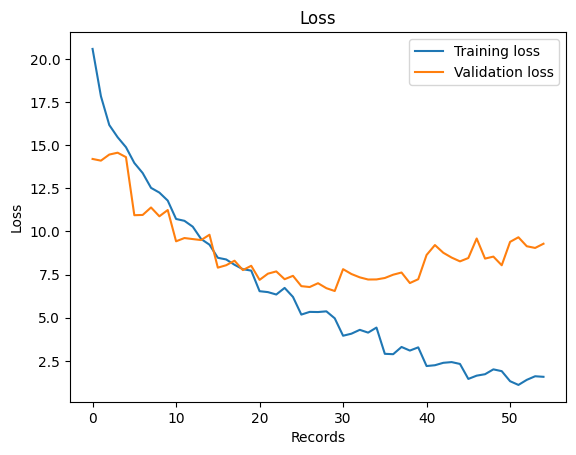

In [ ]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(55, 10)


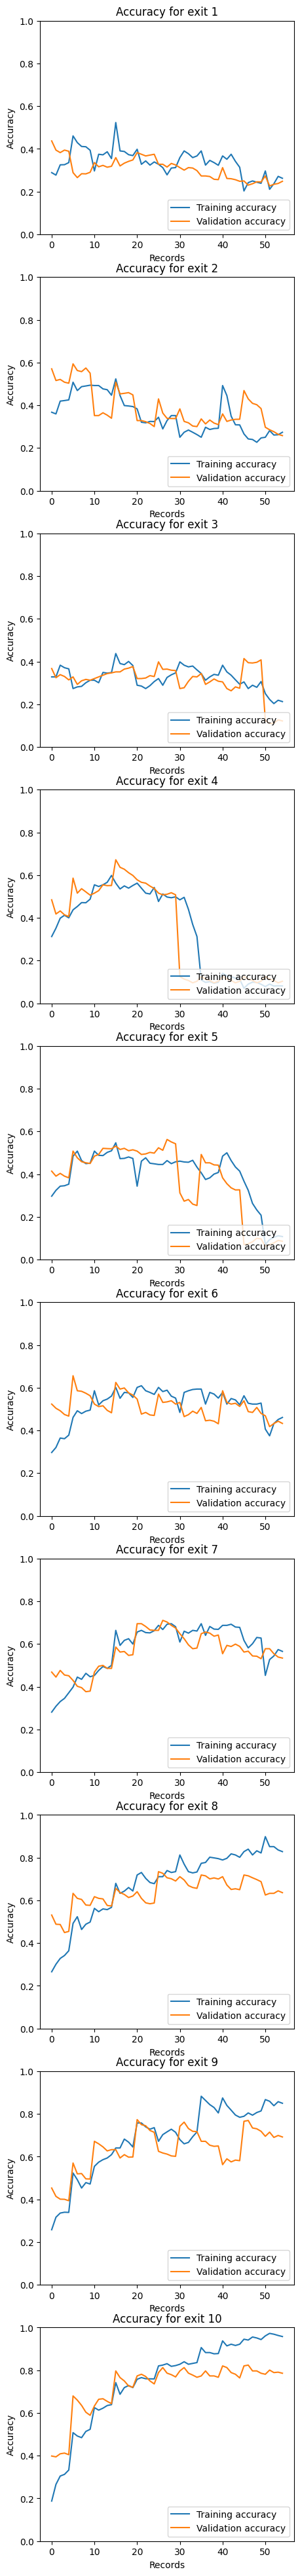

In [ ]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

### Using a different decision criterion for early exit (probability of the output)

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 22:15:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   3065MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class BVGG13_v3(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v3, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                H = find_max_prob(x_ee)
                g_functions.append(H)
                e += 1
                if inference and torch.greater(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        last_H = find_max_prob(x)
        if inference:
            return x, last_H, len(soft_out)

        soft_out.append(x)

        k = len(g_functions) - 1
        for i, o in enumerate(out[-2::-1]):
            h = g_functions[k].unsqueeze(1)
            k -= 1
            # print(h.shape)
            # print(o.shape)
            f_tilde = h * o + (1 - h) * soft_out[-1]
            # print("Early exit", i)
            # print(f_tilde.detach().cpu())
            soft_out.append(f_tilde)

        soft_out.reverse()

        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [ ]:
torch.manual_seed(42)
bvgg_v3 = BVGG13_v3(num_classes=10)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v3.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v3.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v3,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 20.4640	Accuracy: [35.94 38.28 42.19 36.72 35.94 30.47 27.34 26.56 19.53 21.88]
Epoch 1	Training loss: 17.4450	Accuracy: [42.97 41.8  42.58 41.8  37.5  36.33 32.03 30.86 23.44 26.56]
Epoch 1	Training loss: 15.7546	Accuracy: [48.7  44.01 45.31 42.45 39.32 37.24 34.38 32.03 28.65 28.39]
Epoch 1	Training loss: 15.0586	Accuracy: [51.37 45.31 45.9  42.97 40.43 37.5  35.16 33.01 30.47 30.27]
Epoch 1	Training loss: 14.1971	Accuracy: [54.84 47.03 47.19 44.38 42.19 40.   38.12 36.25 32.66 33.91]
Epoch 1	Validation loss: 13.2390	Accuracy: [65.62 54.69 66.41 51.56 59.38 57.81 52.34 46.09 46.88 43.75]
Epoch 1	Validation loss: 13.1241	Accuracy: [62.11 52.34 58.59 49.22 53.52 53.12 48.44 46.48 46.48 45.31]
Epoch 1	Validation loss: 13.4737	Accuracy: [62.24 54.95 59.38 50.78 53.91 52.34 47.14 44.53 45.57 44.79]
Epoch 1	Validation loss: 13.2286	Accuracy: [61.13 55.08 58.01 49.61 53.32 52.34 47.46 44.92 44.92 46.09]
Epoch 1	Validation loss: 13.2955	Accuracy: [61.41 54.53 57.03 49.

### Test data

In [ ]:
# test accuracy
bvgg_v3.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v3(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")

avg_acc = correct / total
print(f"the average accuracy is {100*avg_acc}")

Exit 1 test accuracy: 66.31%
Test took 3.00 seconds
Exit 2 test accuracy: 40.50%
Test took 3.46 seconds
Exit 3 test accuracy: 72.50%
Test took 4.34 seconds
Exit 4 test accuracy: 12.97%
Test took 3.03 seconds
Exit 5 test accuracy: 75.97%
Test took 2.98 seconds
Exit 6 test accuracy: 75.21%
Test took 3.03 seconds
Exit 7 test accuracy: 77.36%
Test took 4.66 seconds
Exit 8 test accuracy: 78.09%
Test took 2.98 seconds
Exit 9 test accuracy: 73.95%
Test took 3.02 seconds
Exit 10 test accuracy: 78.11%
Test took 3.05 seconds
the average accuracy is 78.11


### Inference time

In [ ]:
bvgg_v3.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v3.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v3(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Probability: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00235581 seconds
Exit: 2
Probability: tensor([0.9777])
Output: tensor([[  2.0042, -10.7492,   0.3155,  -4.4660,  -2.5309,   2.5478,  -4.2069,
          -1.6915,   6.8710,  -1.7703]])
Prediction: ship
Target: ship


In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 22:21:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    41W /  70W |   3291MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

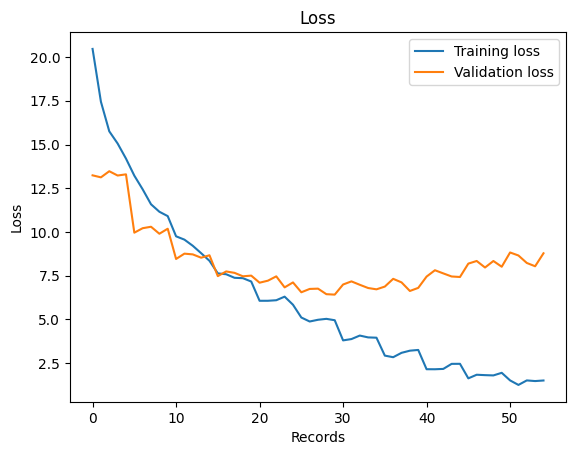

In [ ]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(55, 10)


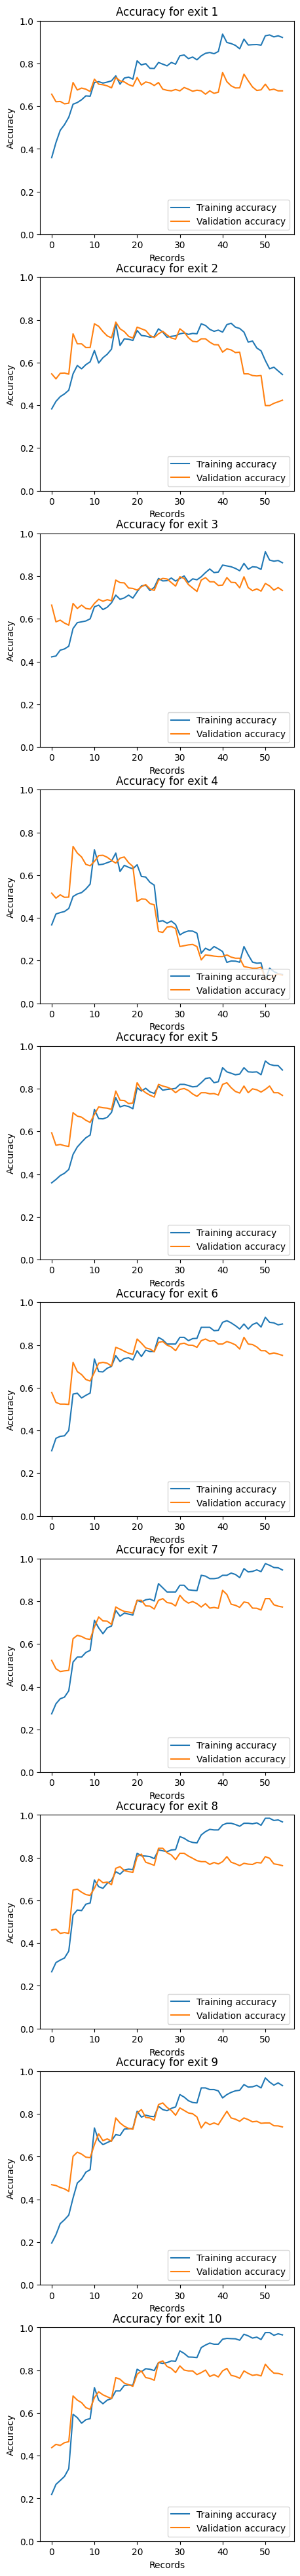

In [ ]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

In [ ]:
print(f"GPU Memory Used: {humanize.naturalsize(gpu.memoryUsed)}")

GPU Memory Used: 0 Bytes
